In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split

# **TP Linear and logistic Regression - Gorse & Monbroussou**

#Part 1 : Multiple Linear Regression

## Preparation of the data :

To work properly with the dataset we download from Kaggle, we delete the column link to the adress and split the entire dataset in one training set and one test set. 

In [ ]:
data = pd.read_csv("USA_Housing.csv")

data = data.drop(columns=['Address'])

data.head()


,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06
3,63345.240046,7.188236,5.586729,3.26,34310.242831,1.260617e+06
4,59982.197226,5.040555,7.839388,4.23,26354.109472,6.309435e+05


In [ ]:
msk = np.random.rand(data.shape[0]) < 0.8

data_train = data[msk]
data_test = data[~msk]

##Correlation matrix :

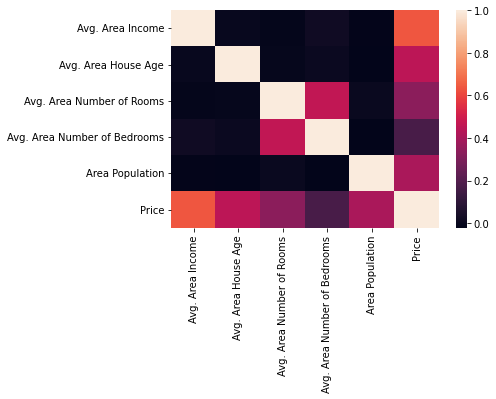

In [ ]:
correlation=data.corr()

sn.heatmap(correlation)

##Use of the linear regression via SVD :

Train MAE: 18506.81016239472
Test MAE: 10948.250773441465


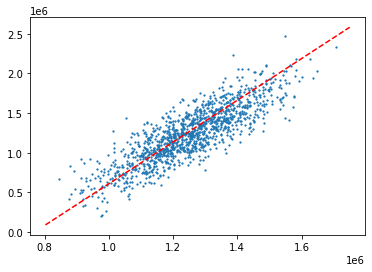

In [ ]:
#Travail Valentin

A = data[["Avg. Area Income", 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Avg. Area Number of Bedrooms', 'Area Population']]
b = data['Price']

#Spliting the dataset with 75% for the training and 25% for the test
X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=0.25, random_state=42)

#Applying the SVD method thanks to python method 
V,D,Vt = np.linalg.svd(X_train, full_matrices=False)

#Compute w for the case of A is not invertible

w = Vt.T @ np.linalg.inv(np.diag(D)) @ V.T @ y_train

#Compute of the price thanks to the coefficient found
train_predictions = X_train @ w
test_predictions = X_test @ w

#Compute of the Mean absolute error for train and test
train_mae = np.mean((train_predictions - y_train))
test_mae = np.mean((test_predictions - y_test))

print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

plt.scatter(test_predictions,y_test,s=1.5)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c="r")


In [ ]:
### Calcul Linear Regression:
training_array = np.array(data_train)

A = np.sum([np.dot(training_array[i], np.transpose(training_array[i])) for i in range(training_array.shape[1])])



#Part 2 : Logistic regression

#Part 2 : Logistic regression

##Theoritical questions :

 We want to show that the gradient of the MSE under linear prediction is given by $\nabla L(w)=\frac{-1}{m}X^T(y-Xw)$ :

We know that from our observation on linear regression that the problem is a minimisation problem depending on w with the function L define as: $L(w) = \frac{1}{2m}||y-Xw||^2=\frac{1}{2m}(y^Ty-2w^TX^Ty+w^TX^TXw)$

We derive with respect to $w^T$ we obtain the result asked. 

\\

 We know from our optimisitation course that The Hessian matrix of a convex function is positive semi-definite.

So here we can compute the Hessian matrix which is equal to :
$\nabla^2L(w)=\frac{1}{m}X^TX$ wich is a PSD matrix by construction. So our function (the cost function (MSE)) is convex 

\\

 For this computation with the logistic regression, we recall that $\sigma(u)=\frac{1}{1+e^{-u}}$. 

For this regression we have $L(w) = - Y log(\sigma(Xw)) - (1-Y)log(\sigma(-Xw))= -Ylog(1+e^{-Xw})-(1-Y)(1+e^{Xw})$

To compute this gradient, we recall that $\sigma(z)=1-\sigma(-z) \implies \sigma(z) + \sigma(-z) = 1$

So $\nabla L(w)=YX^T\sigma(-Xw) + (1-Y)X^T\sigma(Xw)= X^T[-Y(\sigma(Xw)+\sigma(-Xw))+\sigma(Xw)] = X^T[-Y(1)+\sigma(Xw)] =X^T[-Y +\sigma(Xw)]  $

\\

##Practical question :


In [ ]:
def load_data(sub_sample=True, add_outlier=False):
    """Load data and convert it to the metric system."""
    path_dataset = "height_weight_genders.csv"
    data = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, usecols=[1, 2])
    height = data[:, 0]
    weight = data[:, 1]
    gender = np.genfromtxt(
        path_dataset, delimiter=",", skip_header=1, usecols=[0],
        converters={0: lambda x: 0 if b"Male" in x else 1})
    # Convert to metric system
    height *= 0.025
    weight *= 0.454
    return height, weight, gender


def sample_data(y, x, seed, size_samples):
    """sample from dataset."""
    np.random.seed(seed)
    num_observations = y.shape[0]
    random_permuted_indices = np.random.permutation(num_observations)
    y = y[random_permuted_indices]
    x = x[random_permuted_indices]
    return y[:size_samples], x[:size_samples]


def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x


def de_standardize(x, mean_x, std_x):
    """Reverse the procedure of standardization."""
    x = x * std_x
    x = x + mean_x
    return x


def build_model_data(height, weight):
    """Form (y,tX) to get regression data in matrix form."""
    y = weight
    x = height
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    return y, tx


def visualization(y, x, mean_x, std_x, w, save_name, is_LR=False):
    """visualize the raw data as well as the classification result."""
    fig = plt.figure()
    # plot raw data
    x = de_standardize(x, mean_x, std_x)
    ax1 = fig.add_subplot(1, 2, 1)
    males = np.where(y == 1)
    females = np.where(y == 0)
    ax1.scatter(
        x[males, 0], x[males, 1],
        marker='.', color=[0.06, 0.06, 1], s=20)
    ax1.scatter(
        x[females, 0], x[females, 1],
        marker='*', color=[1, 0.06, 0.06], s=20)
    ax1.set_xlabel("Height")
    ax1.set_ylabel("Weight")
    ax1.grid()
    # plot raw data with decision boundary
    ax2 = fig.add_subplot(1, 2, 2)
    height = np.arange(
        np.min(x[:, 0]), np.max(x[:, 0]) + 0.01, step=0.01)
    weight = np.arange(
        np.min(x[:, 1]), np.max(x[:, 1]) + 1, step=1)
    hx, hy = np.meshgrid(height, weight)
    hxy = (np.c_[hx.reshape(-1), hy.reshape(-1)] - mean_x) / std_x
    x_temp = np.c_[np.ones((hxy.shape[0], 1)), hxy]
    # The threshold should be different for least squares and logistic regression when label is {0,1}.
    # least square: decision boundary t >< 0.5
    # logistic regression:  decision boundary sigmoid(t) >< 0.5  <==> t >< 0
    if is_LR:
        prediction = x_temp.dot(w) > 0.0
    else:
        prediction = x_temp.dot(w) > 0.5
    prediction = prediction.reshape((weight.shape[0], height.shape[0]))
    ax2.contourf(hx, hy, prediction, 1)
    ax2.scatter(
        x[males, 0], x[males, 1],
        marker='.', color=[0.06, 0.06, 1], s=20)
    ax2.scatter(
        x[females, 0], x[females, 1],
        marker='*', color=[1, 0.06, 0.06], s=20)
    ax2.set_xlabel("Height")
    ax2.set_ylabel("Weight")
    ax2.set_xlim([min(x[:, 0]), max(x[:, 0])])
    ax2.set_ylim([min(x[:, 1]), max(x[:, 1])])
    plt.tight_layout()
    plt.savefig(save_name)




def sigmoid(t):
    return (1/(1+np.exp(-t)))
    raise NotImplementedError

  
def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood.
    at most 4 lines of code """
    loss = -np.multiply(y,sigmoid(tx.dot(w)))-np.multiply(1-y,1-sigmoid(tx.dot(w)))
    return np.mean(loss)
    raise NotImplementedError

def calculate_gradient(y, tx, w):
    """compute the gradient of loss.
        at most 4 lines of code """
    gradient = np.dot(np.transpose(tx),sigmoid(np.dot(tx,w)) - y)
    return(gradient)
    raise NotImplementedError



#**Using Gradient Descent**
Implement your function to calculate the gradient for logistic regression.

In [ ]:
def learning_by_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descen using logistic regression.
    Return the loss and the updated w.
    Requiers some lines of code
    """
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y,tx,w)
    print(gradient.shape)
    w -= gamma*np.mean(gradient)
    return loss, w
    raise NotImplementedError

In [ ]:
# load data.
height, weight, gender = load_data()

# build sampled x and y.
seed = 1
y = np.expand_dims(gender, axis=1)
X = np.c_[height.reshape(-1), weight.reshape(-1)]
y, X = sample_data(y, X, seed, size_samples=200)
x, mean_x, std_x = standardize(X)

(3, 1)
Current iteration=0, loss=-0.5
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
loss=-0.7326788486103846


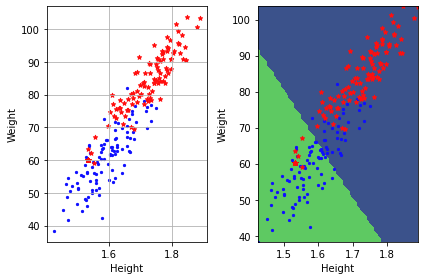

In [ ]:
def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 10000
    threshold = 1e-8
    gamma = 0.01
    losses = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, gamma)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent", True)
    print("loss={l}".format(l=calculate_loss(y, tx, w)))

logistic_regression_gradient_descent_demo(y, x)